In [1]:
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt
%run NNs.ipynb
%run helpers_preproc.ipynb
#yo

In [2]:
#read in the data, get normalized adjacency (NxN)

mesh_dir = 'SHREC11/'

label_np = np.array(readLbl(mesh_dir+'labels.txt'))
label_mat_np = np.where(igl.all_pairs_distances(label_np,label_np,False) > 0.5,0,1)
label_mat = torch.tensor(label_mat_np,requires_grad=False)

type = get_same_type(label_np) #dict of 30 keys, each key contains the indices of that category
test_dict, train_dict = get_test_train(type) #each a dict of some keys (according to test size), each key contains indices of that category

In [3]:
label_mat_train = form_label_matrix(label_mat, train_dict)

torch.Size([450, 450])


In [4]:
normed_adjMats_list_train, node_sigs_list_train = prep_data(train_dict)

NameError: name 'train' is not defined

In [104]:
normed_adjMats_train = np.stack(normed_adjMats_list_train)
node_sigs_train = np.stack(node_sigs_list_train)

normed_adjMats_train = torch.tensor(normed_adjMats_train,requires_grad=False).float()
node_sigs_train = torch.tensor(node_sigs_train,requires_grad=False).float()

normed_adjMats_train = torch.nan_to_num(normed_adjMats_train,0,0,0)
node_sigs_train = torch.nan_to_num(node_sigs_train,0,0,0)

In [105]:
node_sigs_train

tensor([[[4.0000, 0.1011, 0.0000, 0.2601, 0.2601],
         [5.0000, 0.1353, 0.0000, 0.4299, 0.4299],
         [5.0000, 0.0797, 0.0000, 0.2877, 0.2877],
         ...,
         [5.0000, 0.1599, 0.0000, 0.5305, 0.5305],
         [5.0000, 0.1262, 0.0000, 0.4240, 0.4240],
         [5.0000, 0.1794, 0.0000, 0.4435, 0.4435]],

        [[8.0000, 0.0975, 0.0000, 0.5081, 0.5081],
         [5.0000, 0.0975, 0.0000, 0.2521, 0.2521],
         [7.0000, 0.1040, 0.0000, 0.4438, 0.4438],
         ...,
         [6.0000, 0.0804, 0.0000, 0.3440, 0.3440],
         [4.0000, 0.0475, 0.0000, 0.1420, 0.1420],
         [5.0000, 0.0775, 0.0000, 0.2113, 0.2113]],

        [[8.0000, 0.1591, 0.0000, 0.6602, 0.6602],
         [6.0000, 0.1198, 0.0000, 0.3866, 0.3866],
         [5.0000, 0.1226, 0.0000, 0.4488, 0.4488],
         ...,
         [6.0000, 0.1369, 0.0000, 0.5510, 0.5510],
         [5.0000, 0.1372, 0.0000, 0.3345, 0.3345],
         [8.0000, 0.1577, 0.0000, 0.6560, 0.6560]],

        ...,

        [[4.0000, 0.

In [238]:
g = GCN(5,[20,20,20,20])
n = MLP(252*20,[20,20,20,20])
output1 = g.forward(normed_adjMats_train,node_sigs_train)
output2 = n.forward(output1)
print(output1.shape)
print(output2.shape)

torch.Size([450, 252, 20])
torch.Size([450, 20])


In [251]:
def lossF(features):
    disMat = torch.cdist(features,features)
    sameType = disMat * (label_mat_train-torch.diag(torch.ones(450)))
    diffType = disMat * (1-label_mat_train)

    #diffType_mask_threshold = torch.where(diffType > 5,0,1)
    diffTypeScaled = diffType * torch.exp(-diffType)
    diffTypeScaledMean = torch.sum(diffTypeScaled)/ torch.count_nonzero(diffTypeScaled)
    diffTypeMean = torch.sum(diffType)/ torch.count_nonzero(diffType)
    #print(torch.count_nonzero(diffType))

    sameTypeMean = torch.sum(sameType) / torch.count_nonzero(sameType)
    # diffTypeMean = torch.sum(diffType) /348000
    #
    #
    sameTypeStd = torch.sum((sameType - sameTypeMean)**2) / torch.count_nonzero(sameType)
    # diffTypeStd = torch.sum((diffType - diffTypeMean)**2) / (348000 * 0.75)

    print(sameTypeMean.detach().numpy(),diffTypeMean.detach().numpy(),torch.sqrt(sameTypeStd).detach().numpy())
    return  sameTypeMean**2-diffTypeScaledMean**2 + 0.01 * torch.sqrt(sameTypeStd)

In [ ]:
optimizer = optim.Adam(g.weights + n.weights,lr = 0.0001)
for i in range(10000):
    optimizer.zero_grad()
    output = n.forward(g.forward(normed_adjMats_train,node_sigs_train))
    loss = lossF(output)
    loss.backward()
    optimizer.step()

0.087410465 0.7795694 0.52034014
0.14903577 0.69101685 0.84837836
0.113376714 0.71252966 0.651245
0.098435126 0.76070184 0.5721908
0.12730001 0.7979836 0.7303277
0.12156622 0.8099285 0.7007262
0.103720754 0.80238616 0.60523236
0.10253052 0.77573895 0.5978057
0.10534109 0.75177145 0.6097402
0.0977876 0.7405352 0.5672059
0.08945689 0.7440559 0.5240134
0.096536085 0.7577241 0.56171334
0.10330151 0.7685867 0.5994889
0.09727735 0.77422553 0.5673548
0.089324884 0.7738942 0.5276631
0.09515428 0.7672422 0.55798054
0.09737431 0.7615042 0.5684828
0.09100437 0.75918955 0.5346163
0.085138485 0.7611996 0.50639737
0.09236079 0.7627979 0.5414322
0.09344141 0.7618573 0.5463765
0.08740519 0.75876456 0.5162501
0.08632327 0.75592494 0.509517
0.08929096 0.76050586 0.5247409
0.089300506 0.77005553 0.52851534
0.08980678 0.77875555 0.53069925
0.09110301 0.7783928 0.5359632
0.08812283 0.7704715 0.52129656
0.084745765 0.7580672 0.50089514
0.0859977 0.7543285 0.50713056
0.08483369 0.7601641 0.5026014
0.08778576

In [267]:
disMat = torch.cdist(output,output).flatten()
mask_same = torch.tensor(label_mat_train - torch.diag(torch.ones(450)),dtype=bool).flatten()
mask_diff = torch.tensor(1 - label_mat_train,dtype=bool).flatten()
sameComp = disMat[mask_same].detach().numpy()
diffComp = disMat[mask_diff].detach().numpy()
weightsSame = np.ones_like(sameComp) / len(sameComp)
weightsDiff = np.ones_like(diffComp) / len(diffComp)

/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_33803/4182074172.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_same = torch.tensor(label_mat_train - torch.diag(torch.ones(450)),dtype=bool).flatten()
/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_33803/4182074172.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_diff = torch.tensor(1 - label_mat_train,dtype=bool).flatten()


In [268]:
np.mean(diffComp)

0.7389288

In [269]:
diffComp.shape

(195750,)

In [270]:
np.mean(sameComp)

0.09870917

(array([0.25428233, 0.17333007, 0.08603016, 0.05872905, 0.03428507,
        0.02349162, 0.02285671, 0.01936471, 0.01872981, 0.02031708,
        0.01777744, 0.01714253, 0.01777744, 0.01587272, 0.0146029 ,
        0.00984108, 0.01269817, 0.00730145, 0.00984108, 0.01333308,
        0.0076189 , 0.00793636, 0.00666654, 0.00666654, 0.00634909,
        0.00603163, 0.006984  , 0.00603163, 0.00539672, 0.01142836,
        0.00634909, 0.00444436, 0.003492  , 0.00317454, 0.00190473,
        0.00158727, 0.00095236, 0.00253963, 0.00285709, 0.00285709,
        0.00126982, 0.00031745, 0.00222218, 0.00444436, 0.00126982,
        0.00222218, 0.00095236, 0.00063491, 0.00063491, 0.00031745,
        0.00095236, 0.00158727, 0.00380945, 0.00063491, 0.00031745,
        0.00031745, 0.        , 0.00063491, 0.00095236, 0.00063491,
        0.00126982, 0.00031745, 0.        , 0.        , 0.        ,
        0.        , 0.00063491, 0.00095236, 0.00190473, 0.00158727,
        0.00222218, 0.00031745, 0.00031745, 0.  

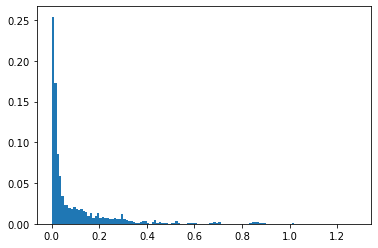

In [271]:
plt.hist(sameComp,bins=np.arange(0,np.max(sameComp),0.01),weights=weightsSame,log = False)

(array([1.31800766e-03, 3.54533844e-03, 5.02681992e-03, 4.87356322e-03,
        5.84418902e-03, 5.38441890e-03, 5.99744572e-03, 6.50830140e-03,
        6.68199234e-03, 7.47892720e-03, 7.96934866e-03, 7.75478927e-03,
        8.66411239e-03, 7.94891443e-03, 6.98850575e-03, 7.13154534e-03,
        7.25415070e-03, 8.51085568e-03, 8.39846743e-03, 6.85568327e-03,
        7.03959132e-03, 6.59003831e-03, 6.63090677e-03, 7.71392082e-03,
        7.68326948e-03, 5.70114943e-03, 6.98850575e-03, 7.11111111e-03,
        6.34482759e-03, 7.23371648e-03, 7.47892720e-03, 7.65261814e-03,
        7.62196679e-03, 8.13282248e-03, 6.82503193e-03, 5.63984674e-03,
        5.24137931e-03, 4.60791826e-03, 4.95530013e-03, 7.66283525e-03,
        6.36526181e-03, 5.33333333e-03, 5.26181354e-03, 5.87484036e-03,
        6.53895275e-03, 5.80332056e-03, 5.09833972e-03, 5.94636015e-03,
        5.90549170e-03, 6.61047254e-03, 8.08173691e-03, 7.32567050e-03,
        7.39719029e-03, 6.43678161e-03, 5.70114943e-03, 6.263090

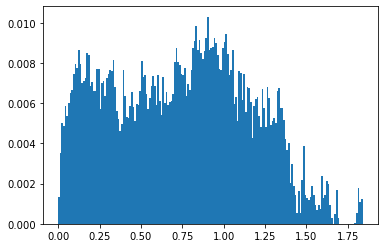

In [272]:
#from matplotlib.pyplot import figure
#figure(figsize=(10, 8), dpi=80)
plt.hist(diffComp,bins=np.arange(0,np.max(diffComp),0.01),weights=weightsDiff,log = False)

In [66]:
BigDiffIndices = np.where(disMat.detach().numpy().flatten() > 0.1)[0].tolist()

In [67]:
len(BigDiffIndices)

82676

In [68]:
vizMat = np.zeros([30,30])
vizMat

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0

In [69]:
for index in BigDiffIndices:
    row, col = divmod(index,600)
    cat1, cat2 = int(label_np[row]),int(label_np[col])
    #print(cat1,cat2, (cat1 == cat2))
    vizMat[cat1,cat2] += 1
    vizMat[cat2,cat1] += 1


In [70]:
vizMat = vizMat / np.max(vizMat)
vizMat

array([[0.55813953, 0.59468439, 0.53156146, 0.77076412, 0.5448505 ,
        0.49833887, 0.42857143, 0.67109635, 0.51827243, 0.62126246,
        0.43853821, 0.53156146, 0.56146179, 0.46179402, 0.66445183,
        0.62790698, 0.70099668, 0.49169435, 0.38870432, 0.64451827,
        0.64784053, 0.64119601, 0.5448505 , 0.78405316, 0.6345515 ,
        0.6345515 , 0.62126246, 0.63787375, 0.54152824, 0.55481728],
       [0.59468439, 0.61129568, 0.5448505 , 0.89036545, 0.62458472,
        0.55481728, 0.51495017, 0.72757475, 0.55813953, 0.68438538,
        0.52159468, 0.53488372, 0.61129568, 0.49169435, 0.73421927,
        0.63787375, 0.80730897, 0.51495017, 0.43189369, 0.68770764,
        0.69435216, 0.68438538, 0.61461794, 0.85714286, 0.73754153,
        0.6744186 , 0.6744186 , 0.72093023, 0.58471761, 0.62458472],
       [0.53156146, 0.5448505 , 0.45847176, 0.68438538, 0.48504983,
        0.41860465, 0.3986711 , 0.62126246, 0.4717608 , 0.56146179,
        0.40199336, 0.49501661, 0.48837209, 0.

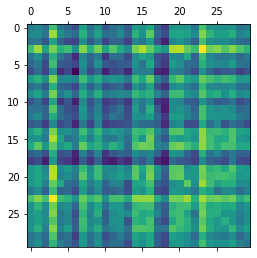

In [71]:
plt.matshow(vizMat)